<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/classic/dt-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning using Decisicon Trees

## Exericse I: Getting familiar with Colab Notebooks

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
plt.xkcd()

Populating the interactive namespace from numpy and matplotlib


# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  95313      0 --:--:-- --:--:-- --:--:-- 94975


In [0]:
import pandas as pd
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [4]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [5]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


## First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [0]:
# we deliberately decide this is going to be our label, it is often called lower case y
y=df['group']

In [7]:
y.head()

0    1
1    1
2    0
3    2
4    1
Name: group, dtype: int64

In [0]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [9]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [0]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.as_matrix()

### We restrict ourselves to two dimensions for now

Because this is all we really can visualize in 2d

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=300, proba=False, prediction=True, 
                   legend=False # colab has old version of matplotlib, does not support
                  ):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T).sample(n_samples, random_state=42)
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=100, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1416283be0>,
 <matplotlib.collections.PathCollection at 0x7f1416235cc0>)

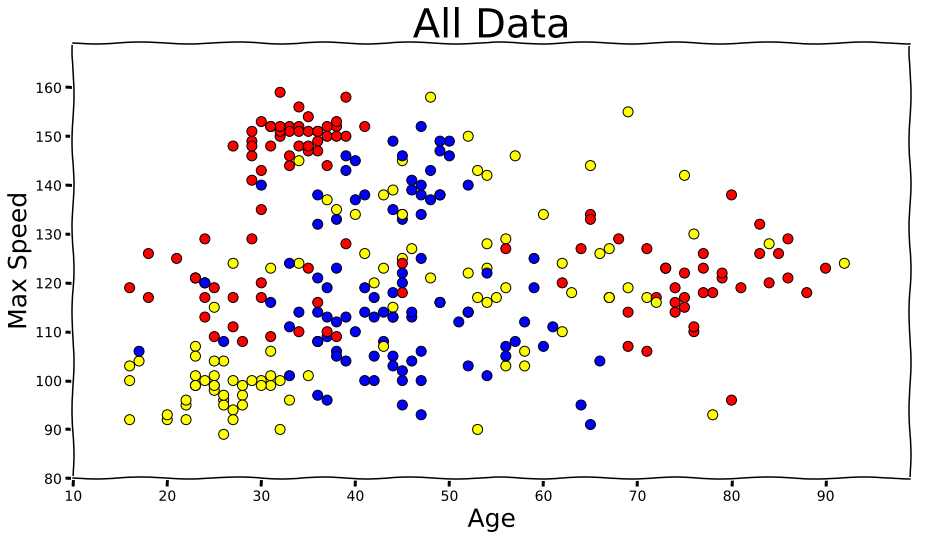

In [12]:
plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data")

In [13]:
# just two dimensions
X[:, :2]

array([[ 98.,  44.],
       [118.,  54.],
       [111.,  26.],
       ...,
       [138.,  41.],
       [100.,  31.],
       [100.,  58.]])

In [14]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
%time clf.fit(X[:, :2], y)

CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 3.02 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
input = [[100.0, 48.0]]
clf.predict(input)

array([1])

# Stop here

## Exercise II: Getting your feet wet fighting overfitting

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization.jpg'>

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200, 3), (1200,), (300, 3), (300,))

In [0]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f140448b048>,
 <matplotlib.collections.PathCollection at 0x7f14044b74e0>)

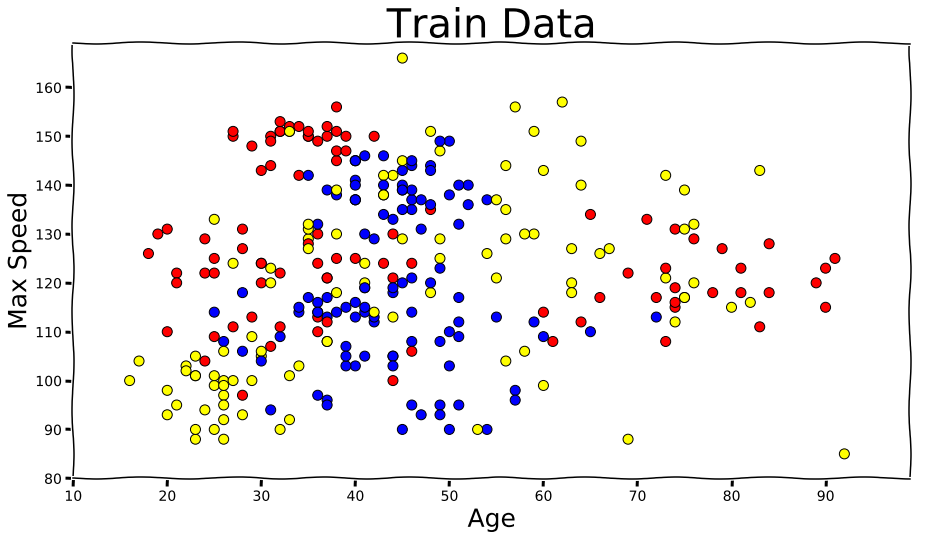

In [18]:
plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, title="Train Data")

(<matplotlib.axes._subplots.AxesSubplot at 0x7f14139b10f0>,
 <matplotlib.collections.PathCollection at 0x7f140441ea58>)

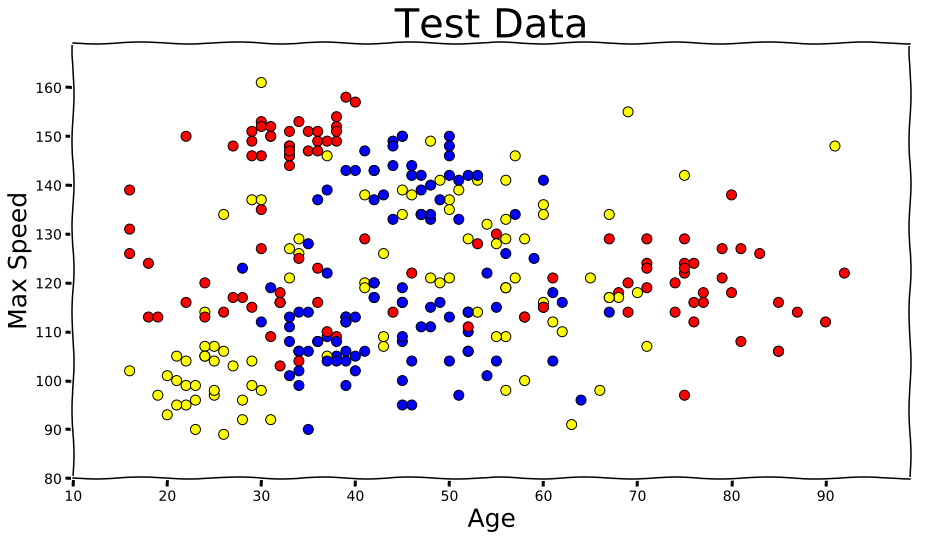

In [19]:
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, title="Test Data")

### What is the best split?

* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/


In [20]:
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.97 ms, sys: 993 µs, total: 3.97 ms
Wall time: 9.47 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
# we perform at most 18 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

18

(<matplotlib.axes._subplots.AxesSubplot at 0x7f14043e0160>,
 <matplotlib.collections.PathCollection at 0x7f14043504a8>)

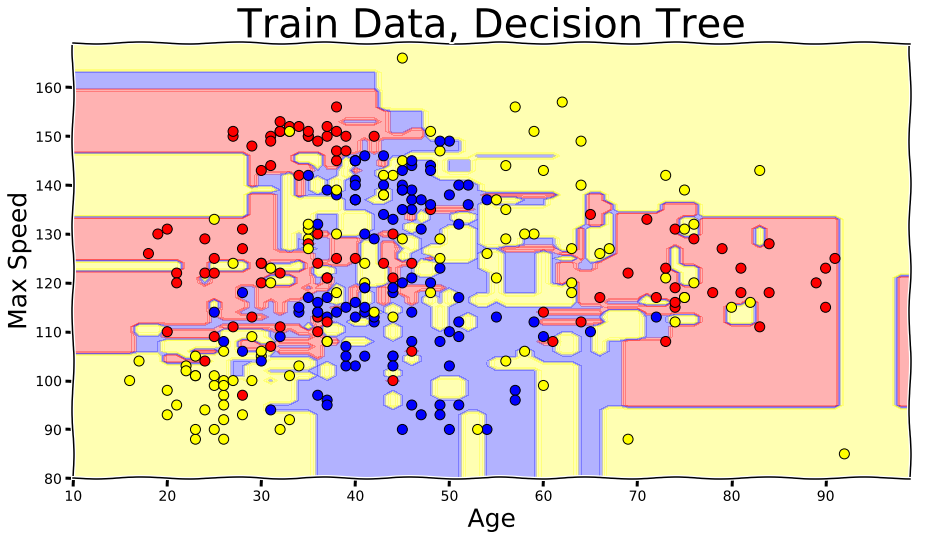

In [22]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree")

In [23]:
clf.score(X_train_2_dim, y_train)

0.9425

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1413995ba8>,
 <matplotlib.collections.PathCollection at 0x7f1404301dd8>)

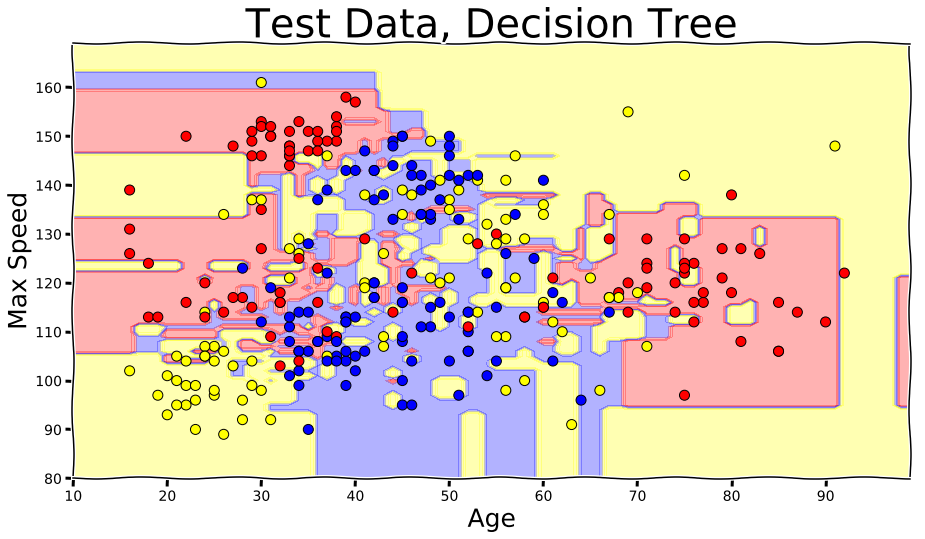

In [24]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree")

In [25]:
clf.score(X_test_2_dim, y_test)

0.5966666666666667

In [26]:
clf = DecisionTreeClassifier(max_depth=10,
                              min_samples_leaf=3,
                              min_samples_split=2)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.3 ms, sys: 93 µs, total: 2.39 ms
Wall time: 2.45 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [27]:
clf.tree_.max_depth

10

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1404315a90>,
 <matplotlib.collections.PathCollection at 0x7f140420bba8>)

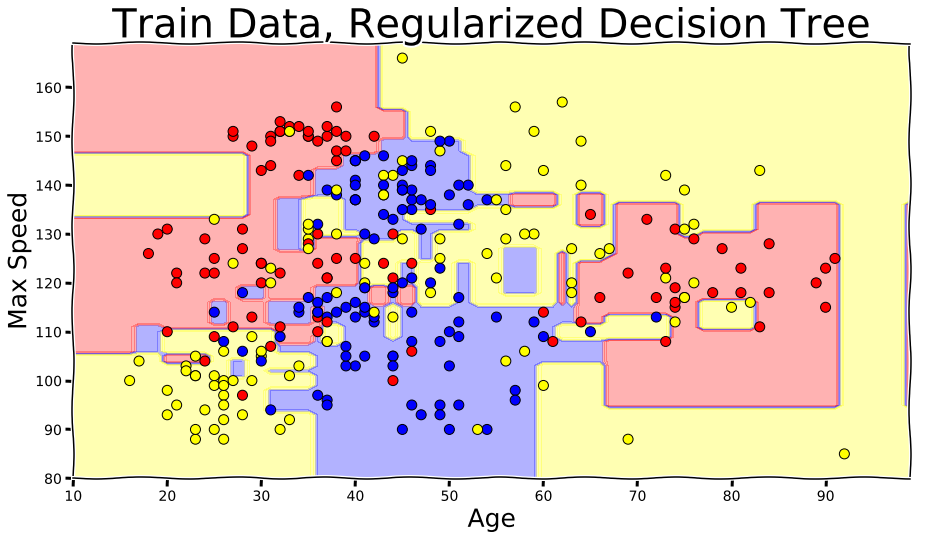

In [28]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree")

In [29]:
clf.score(X_train_2_dim, y_train)

0.8016666666666666

(<matplotlib.axes._subplots.AxesSubplot at 0x7f140428d400>,
 <matplotlib.collections.PathCollection at 0x7f14041937b8>)

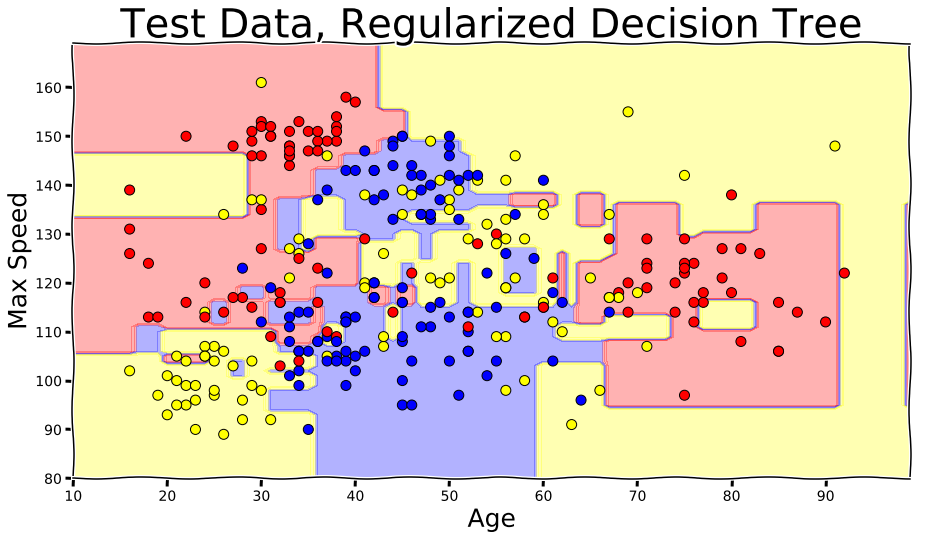

In [30]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Decision Tree")

In [31]:
clf.score(X_test_2_dim, y_test)

0.6366666666666667

# STOP HERE 

## optional material: automatic regularization

In [32]:
# http://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X[:, :2], y, n_jobs=-1)
scores

array([0.6506986, 0.644    , 0.6492986])

In [0]:
# cross_val_score?

In [34]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.65 (+/- 0.01)


In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1)
%time clf.fit(X[:, :2], y)
clf.best_params_

CPU times: user 3.02 s, sys: 24 ms, total: 3.04 s
Wall time: 10.4 s


{'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [36]:
clf = DecisionTreeClassifier(max_depth=6,
                              min_samples_leaf=6,
                              min_samples_split=2)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.36 ms, sys: 75 µs, total: 2.43 ms
Wall time: 1.78 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
clf.score(X_train_2_dim, y_train)

0.7233333333333334

In [38]:
clf.score(X_test_2_dim, y_test)

0.6633333333333333

In [39]:
# http://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X[:, :2], y, n_jobs=-1)
scores

array([0.67664671, 0.694     , 0.68537074])

In [40]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.01)
